In [10]:
import importlib
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
from torchvision.ops.misc import interpolate
from tqdm.notebook import tqdm as tqdm_notebook

#### Custum libraries
import lib.algos_maxRSA as max_rsa
import lib.utils_RSA as rsa
import lib.utils_CKA as cka
from lib.algos import *
from scipy.spatial import procrustes as scipro

from lib.algos_maxRSA import find_max_dissimilarity_images

importlib.reload(rsa)
importlib.reload(cka)
importlib.reload(max_rsa)

<module 'lib.algos_maxRSA' from '/home/alban/projects/SAYCam_Vs_EGO4D/lib/algos_maxRSA.py'>

In [2]:
dataset = 'ecoVal'
#models  = ['ego', 'saycam', 'imagenet', 'supervised', 'random', 'resnet']
models  = ['ego', 'saycam']
path2activations = f'/home/alban/Documents/activations_datadriven/%s_{dataset}/'

imagelists = {}
activations = {}
for model in models:
    with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
        imagelists[model] = [line.strip() for line in f.readlines()]
    activations[model] = np.load(join(path2activations % model, 'cls_tokens.npy'))

activations[model].shape

(28250, 768)

In [3]:
#### Normalize vectors
for model in models:
    norms = np.linalg.norm(activations[model], axis=1, keepdims=True)
    activations[model] = activations[model]/norms # normalization

In [4]:
#### Compute RDMs performing squared euclidean distance as a metric (to be equivalent to CKA methods, cf. Williams, 2024)
RDMs = {}

metric = 'L2squared'
for i, model in enumerate(models):
    print(model)
    RDMs[model] = rsa.compute_RDMs(activations[model], metric = metric, display = False, title = f'{model}_{metric}')
    RDMs[model] = cka.centering(RDMs[model]) # same as centering with matmul


ego
saycam


In [18]:
### Compute similarities between models and metrics.
sim_metric = 'cosine'

SIMs = {} # save all similarity values in a dictionary

for i, model1 in enumerate(models[:-1]):
    SIMs[model1] = {}
    for j, model2 in enumerate(models[i+1:]):
        SIMs[model1][model2] = float(np.round(rsa.Compute_sim_RDMs(RDMs[model1], RDMs[model2], center = False, metric = 'cosine'), 3))

#SIMs_saycam_ego = np.float64(0.6297048936065802) or 0.649# already computed
SIMs

{'ego': {'saycam': 0.6620000004768372}}

In [5]:
### check if images were shown in the same order
assert imagelists['ego'] == imagelists['saycam']
imagelist = imagelists['ego'] # since they are the same, only consider one list

#### check if each category has the same number of images and list all categories in listcats
count = 0
cat = ''
listcat = list()
for i, imgp in enumerate(imagelist):
    current_cat = imgp.split('/')[-2]
    if i == 0:
        cat = current_cat
        listcat.append(current_cat)
    if cat != current_cat:
        cat = current_cat
        listcat.append(current_cat)
        count = 1
    else:
        count += 1

nb_per_cat = count # in val, 50 images per cate

nb_per_cat
#np.array(imagelist).reshape(-1, nb_per_cat)[0]

50

In [6]:
def compute_rdm_column_similarities_vectorized(rdm1, rdm2, return_similarities=False):
    """
    Vectorized version for better performance with large RDMs.

    Parameters and returns are the same as compute_rdm_column_similarities.
    """

    # Ensure inputs are numpy arrays
    rdm1 = np.array(rdm1)
    rdm2 = np.array(rdm2)

    # Check that RDMs have the same shape
    if rdm1.shape != rdm2.shape:
        raise ValueError(f"RDMs must have the same shape. Got {rdm1.shape} and {rdm2.shape}")

    # Check that RDMs are square
    if rdm1.shape[0] != rdm1.shape[1]:
        raise ValueError(f"RDMs must be square matrices. Got shape {rdm1.shape}")

    # Compute dot products between corresponding columns
    dot_products = np.sum(rdm1 * rdm2, axis=0)

    # Compute norms for each column
    norms1 = np.linalg.norm(rdm1, axis=0)
    norms2 = np.linalg.norm(rdm2, axis=0)

    # Compute cosine similarities
    # Handle division by zero for zero vectors
    denominator = norms1 * norms2
    similarities = np.where(denominator != 0, dot_products / denominator, 0.0)

    # Sort indices by similarity (lowest to highest)
    sorted_indices = np.argsort(similarities)

    if return_similarities:
        return sorted_indices, similarities[sorted_indices]
    else:
        return sorted_indices

indices_vec, similarities = compute_rdm_column_similarities_vectorized(
        RDMs['ego'], RDMs['saycam'], return_similarities=True
    )



In [9]:
rdm1 = RDMs['ego'][np.ix_(indices_vec[:40], indices_vec[:40])]
rdm2 = RDMs['saycam'][np.ix_(indices_vec[:40], indices_vec[:40])]
float(rsa.Compute_sim_RDMs(rdm1, rdm2, center = False, metric = 'cosine'))

0.5003106594085693

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

def display_low_similarity_images(image_paths, indices_vectorized, n_images=40,
                                 grid_cols=8, figsize=(20, 10), save_path=None):
    """
    Load and display the first n images corresponding to lowest similarity indices.

    Parameters:
    -----------
    image_paths : list
        List of image file paths matching the RDM column indices
    indices_vectorized : numpy.ndarray
        Column indices sorted from lowest to highest similarity
    n_images : int
        Number of images to display (default: 40)
    grid_cols : int
        Number of columns in the display grid (default: 8)
    figsize : tuple
        Figure size for matplotlib (default: (20, 10))
    save_path : str, optional
        Path to save the figure (if None, just display)

    Returns:
    --------
    loaded_images : list
        List of loaded images (as numpy arrays)
    valid_paths : list
        List of valid image paths that were successfully loaded
    """

    # Get the indices for the first n_images with lowest similarity
    low_similarity_indices = indices_vectorized[:n_images]

    # Get corresponding image paths
    selected_paths = [image_paths[idx] for idx in low_similarity_indices]

    loaded_images = []
    valid_paths = []
    valid_indices = []

    print(f"Loading {n_images} images with lowest RDM column similarity...")

    # Load images
    for i, (path, orig_idx) in enumerate(zip(selected_paths, low_similarity_indices)):
        try:
            # Check if file exists
            if not os.path.exists(path):
                print(f"Warning: File not found: {path}")
                continue

            # Load image with cv2
            img = cv2.imread(path)

            if img is None:
                print(f"Warning: Could not load image: {path}")
                continue

            # Convert BGR to RGB for matplotlib display
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            loaded_images.append(img_rgb)
            valid_paths.append(path)
            valid_indices.append(orig_idx)

        except Exception as e:
            print(f"Error loading {path}: {e}")
            continue

    print(f"Successfully loaded {len(loaded_images)} out of {n_images} requested images")

    if len(loaded_images) == 0:
        print("No images could be loaded!")
        return [], []

    # Calculate grid dimensions
    n_loaded = len(loaded_images)
    grid_rows = (n_loaded + grid_cols - 1) // grid_cols

    # Create figure and display images
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=figsize)
    fig.suptitle(f'Images with Lowest RDM Column Similarity (First {n_loaded} images)',
                 fontsize=16, y=0.98)

    # Handle case where we have only one row
    if grid_rows == 1:
        axes = axes.reshape(1, -1)

    for i in range(grid_rows * grid_cols):
        row = i // grid_cols
        col = i % grid_cols
        ax = axes[row, col]

        if i < len(loaded_images):
            # Display image
            ax.imshow(loaded_images[i])

            # Add title with original index and filename
            filename = Path(valid_paths[i]).name
            label = valid_paths[i].split('/')[-2]
            ax.set_title(f'Label: {label }\n{filename[:20]}...',
                        fontsize=8, pad=2)

        ax.axis('off')

    plt.tight_layout()

    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()

    return loaded_images, valid_paths

Loading 40 images with lowest RDM column similarity...
Successfully loaded 40 out of 40 requested images
Figure saved to: figures/images_lowest_colinearity.png


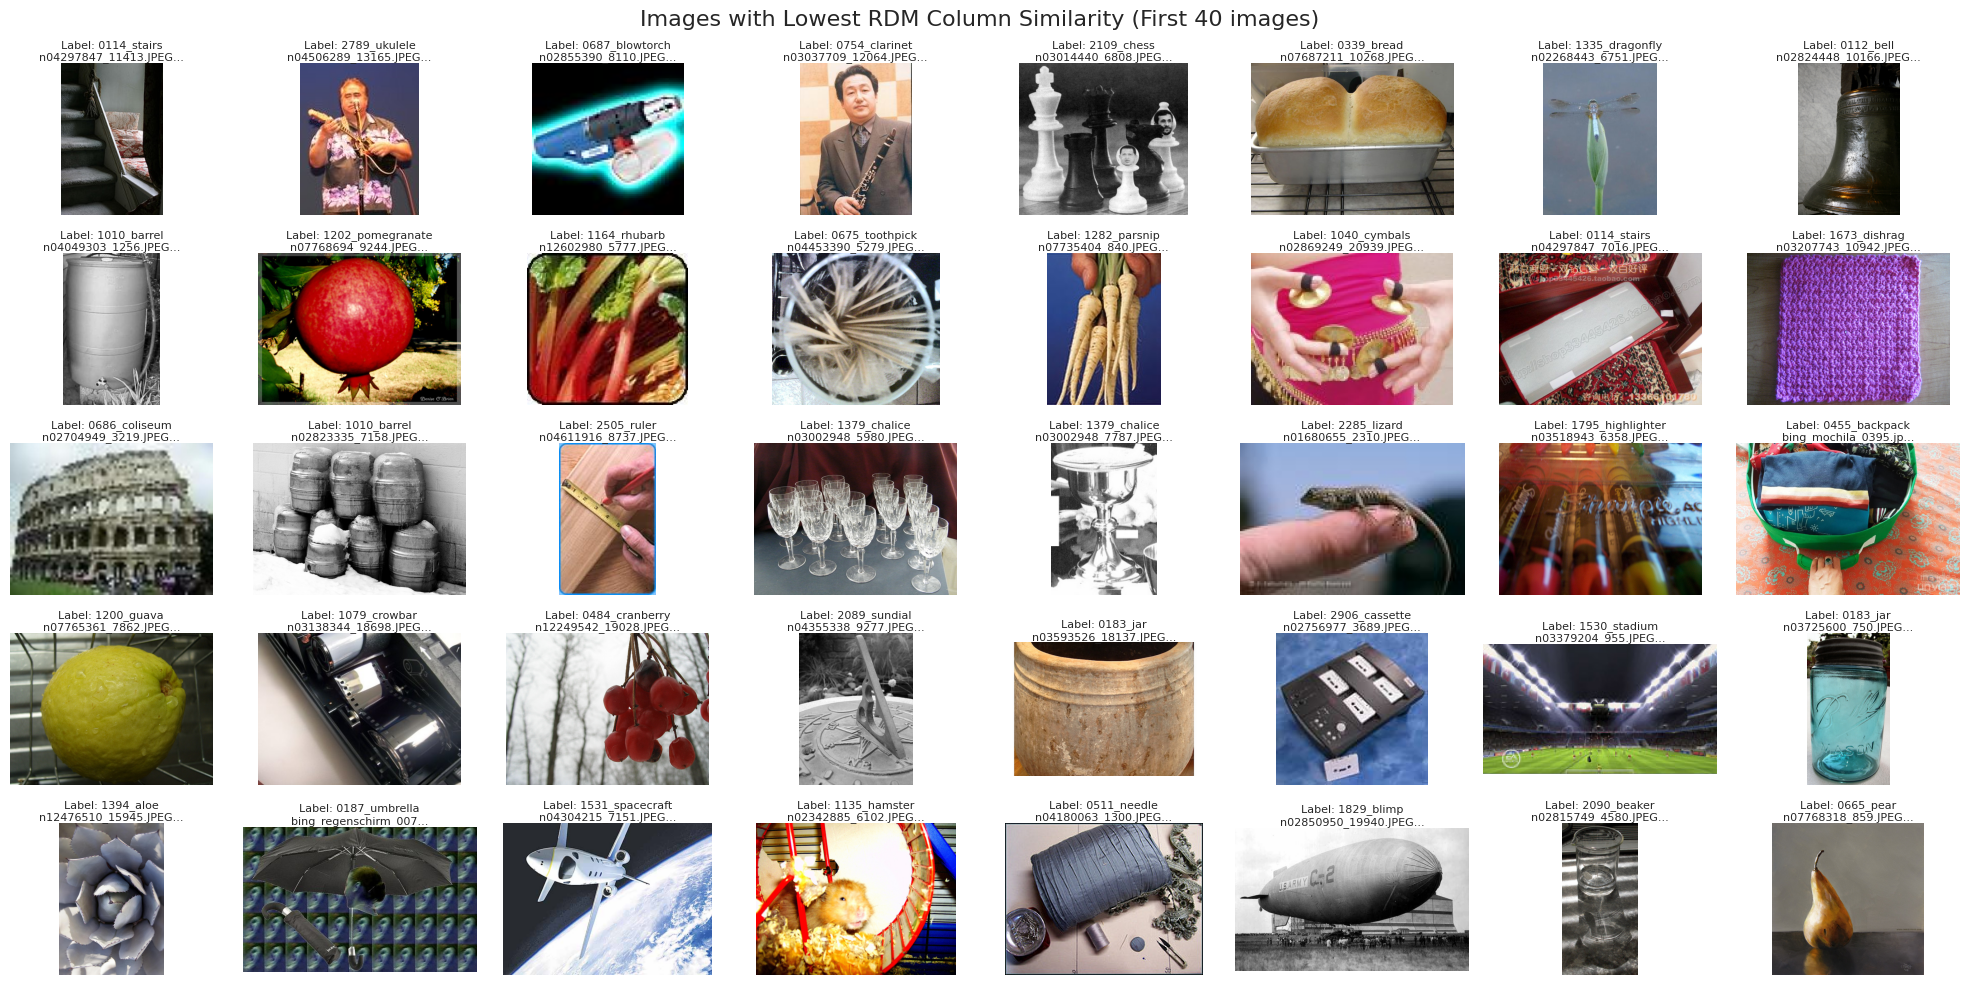

In [32]:
imagelist = [img.replace('/raid/shared/datasets/visoin/', '/home/alban/Documents/') for img in imagelist]
images, paths = display_low_similarity_images(imagelist, indices_vec, n_images=40,
                                 grid_cols=8, figsize=(20, 10), save_path='figures/images_lowest_colinearity.png')